In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Загрузка данных Амазона
df = pd.read_csv('exel_files/amazon_delivery.csv')

#Преобразование типов данных
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Order_Time'] = pd.to_datetime(df['Order_Time'], format='%H:%M:%S', errors='coerce').dt.time
df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], format='%H:%M:%S', errors='coerce').dt.time

#Обработка пропущенных значений
df.dropna(inplace=True)

## 1. Корреляционный анализ

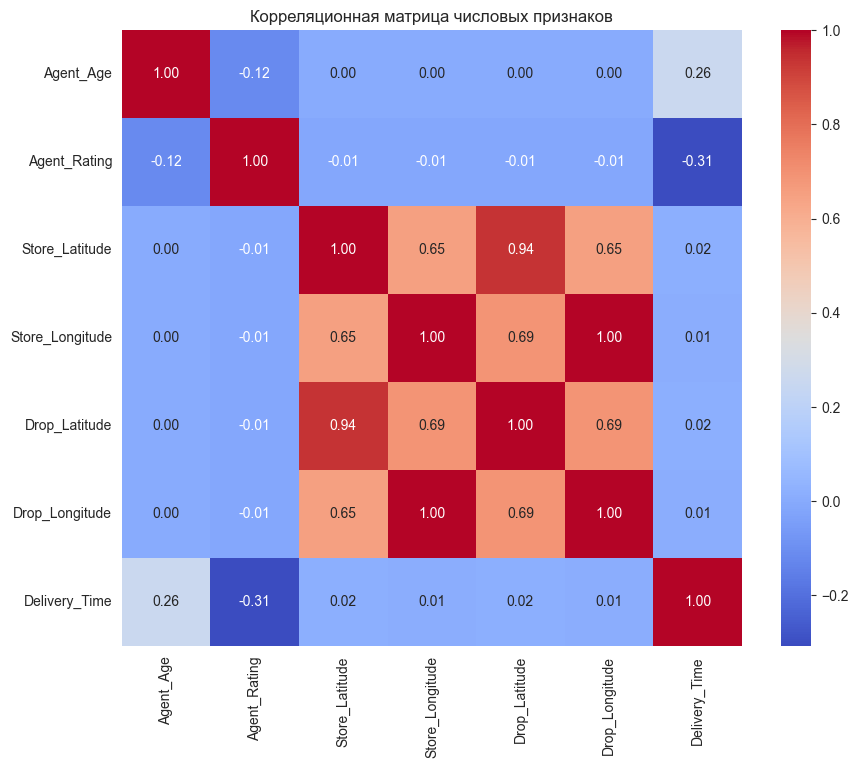

Корреляция с Delivery_Time:
Delivery_Time      1.000000
Agent_Age          0.258463
Drop_Latitude      0.017279
Store_Latitude     0.016890
Drop_Longitude     0.012287
Store_Longitude    0.011805
Agent_Rating      -0.307725
Name: Delivery_Time, dtype: float64


In [30]:
#Вычисление корреляционной матрицы для числовых признаков
numerical_features = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

print('Корреляция с Delivery_Time:')
print(correlation_matrix['Delivery_Time'].sort_values(ascending=False))

## 2. Влияние категориальных признаков на время доставки

### 2.1. Влияние категории товаров

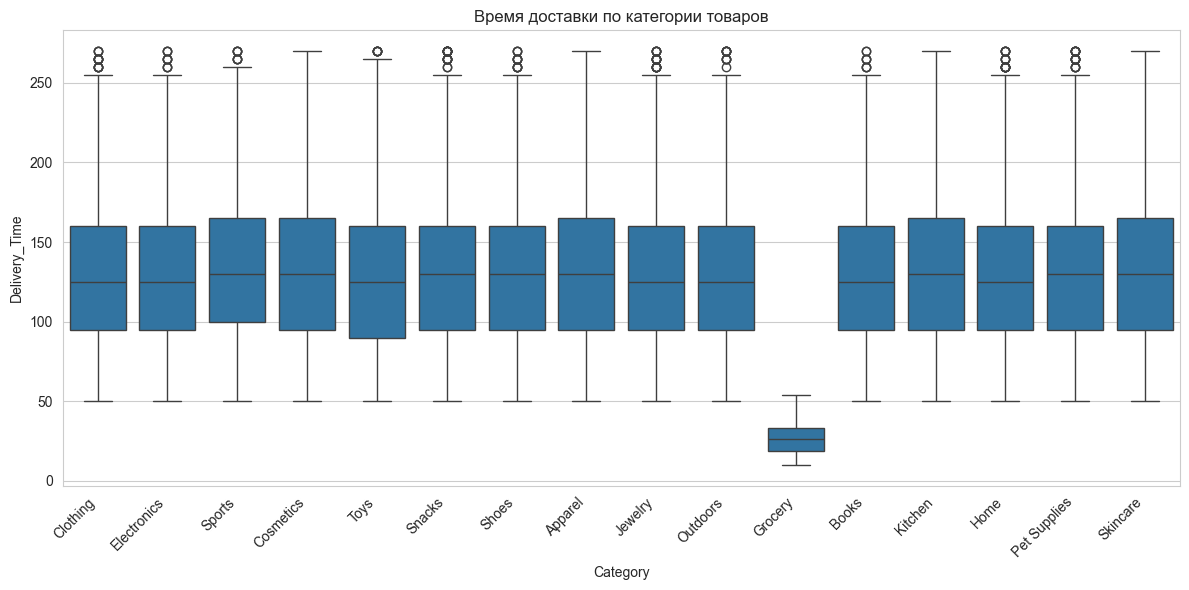

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='Delivery_Time', data=df)
plt.title('Время доставки по категории товаров')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.2 Влияние типа транспортного средства

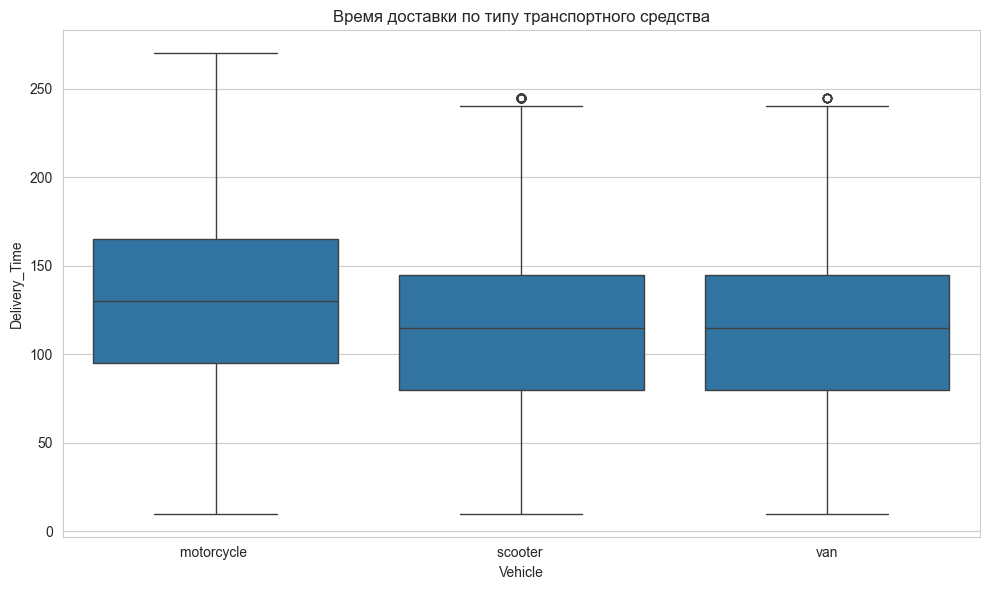

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Vehicle', y='Delivery_Time', data=df)
plt.title('Время доставки по типу транспортного средства')
plt.tight_layout()
plt.show()

### 2.3. Влияние погоды

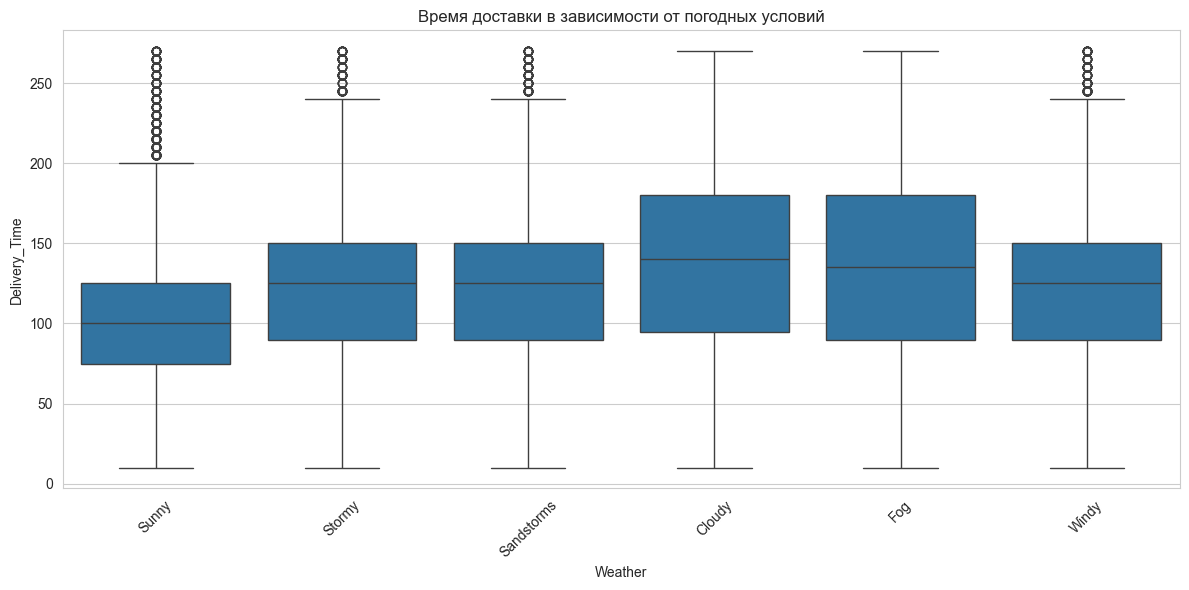

In [33]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Weather', y='Delivery_Time', data=df)
plt.title('Время доставки в зависимости от погодных условий')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.4. Влияние трафика

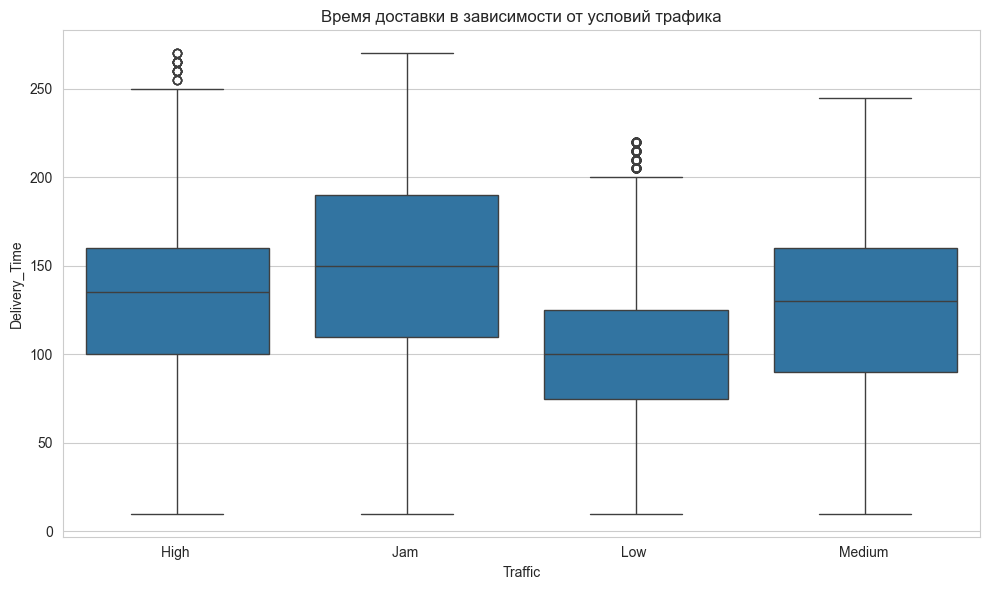

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Traffic', y='Delivery_Time', data=df)
plt.title('Время доставки в зависимости от условий трафика')
plt.tight_layout()
plt.show()

### 2.5. Подготовка данных для моделей

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from math import radians, sin, cos, sqrt, atan2

#Установка стиля для графиков
sns.set_style('whitegrid')

#Удаление не используемых столбцов
df.dropna(inplace=True)
df.drop(columns=['Order_ID', 'Order_Date', 'Order_Time', 'Pickup_Time'], inplace=True)

#Расчет расстояния (Формула Гаверсинуса) - Ключевой признак
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 #Радиус Земли в км
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

df['Distance_km'] = df.apply(
    lambda row: haversine(row['Store_Latitude'], row['Store_Longitude'], row['Drop_Latitude'], row['Drop_Longitude']),
    axis=1
)

#Удаление координат после расчета расстояния
df.drop(columns=['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude'], inplace=True)


## 3. Прогнозирование времени доставки (Регрессия)

### 3.1 Создание нового признака для классификация: 'Is_Late' Порог задержки: более 75-го перцентиля времени доставки

In [36]:
delay_threshold = df['Delivery_Time'].quantile(0.75)
df['Is_Late'] = (df['Delivery_Time'] > delay_threshold).astype(int)
print(f'Порог задержки (75-й перцинтель) установлен на: {delay_threshold:.2f} минут.')
df.head()

Порог задержки (75-й перцинтель) установлен на: 160.00 минут.


,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance_km,Is_Late
0,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,157.167163,0
1,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,1122.805145,1
2,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,87.367285,0
3,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,318.624865,0
4,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,344.620929,0


In [37]:
#Целевая переменная: Delivery_Time
X = df.drop(columns=['Delivery_Time', 'Is_Late'])
y = df['Delivery_Time']
print("Финальные колонки X для модели:", X.columns.tolist())
#Определение типов признака
numerical_indices = [0, 1, 7]
categorical_indices = [2, 3, 4, 5, 6]
numerical_features_names = ['Agent_Age', 'Agent_Rating', 'Distance_km']
categorical_features_names = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']

#конвейер предобработки (Pipeline)
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_indices),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_indices)
    ],
    remainder='drop'
)

Финальные колонки X для модели: ['Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Category', 'Distance_km']


In [38]:
#Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_reg = X_train_reg.reset_index(drop=True)
X_test_reg = X_test_reg.reset_index(drop=True)

#Применение предобработки
X_train_reg_processed = preprocessor_reg.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor_reg.transform(X_test_reg)

#Обучение модели (Random Forest Regressor)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_reg_processed, y_train_reg)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
y_pred_reg = model_rf.predict(X_test_reg_processed)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f'MAE (Средняя абсолютная ошибка): {mae_reg:.2f} минут')
print(f'R-квадрат (Объясненная дисперсия): {r2_reg:.4f}')

MAE (Средняя абсолютная ошибка): 17.97 минут
R-квадрат (Объясненная дисперсия): 0.7889


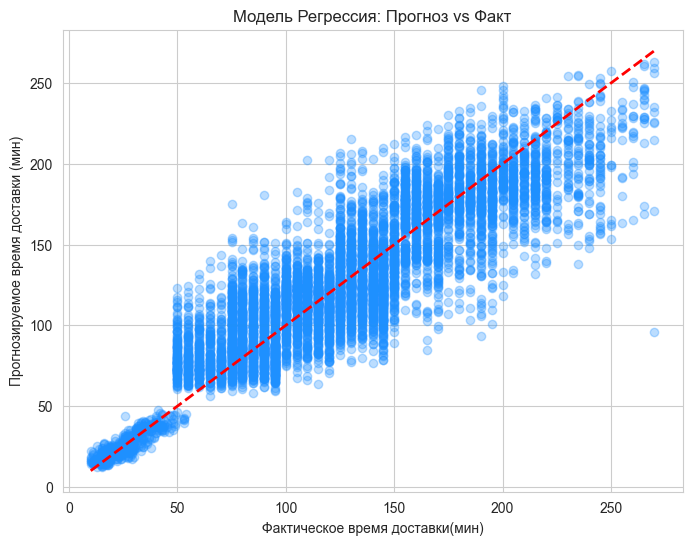

In [40]:
#Сравнения прогноза и факта
plt.figure(figsize=(8,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3, color='dodgerblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Модель Регрессия: Прогноз vs Факт')
plt.xlabel('Фактическое время доставки(мин)')
plt.ylabel('Прогнозируемое время доставки (мин)')
plt.show()

C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_19580\473557990.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_importances.values, y=top_10_importances.index, palette='viridis')


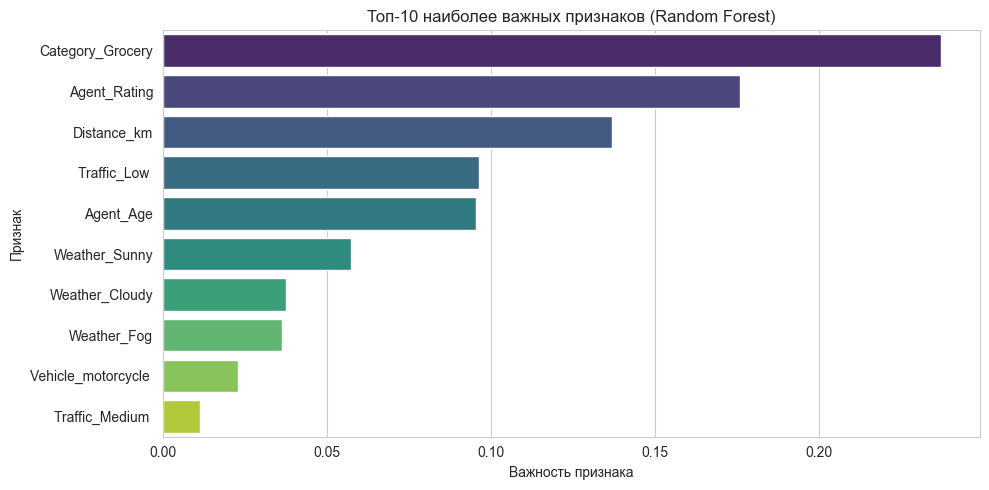


Топ-10 наиболее важных признаков:
Category_Grocery       0.237130
Agent_Rating           0.175869
Distance_km            0.136802
Traffic_Low            0.096399
Agent_Age              0.095441
Weather_Sunny          0.057293
Weather_Cloudy         0.037530
Weather_Fog            0.036249
Vehicle_motorcycle     0.022886
Traffic_Medium         0.011370
dtype: float64


In [41]:
#Важность признаков
cat_feature_names_out = list(
    preprocessor_reg.named_transformers_['cat'].get_feature_names_out(categorical_features_names)
)

feature_names = numerical_features_names + cat_feature_names_out

importances = pd.Series(model_rf.feature_importances_, index=feature_names)
top_10_importances = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_10_importances.values, y=top_10_importances.index, palette='viridis')
plt.title('Топ-10 наиболее важных признаков (Random Forest)')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

print('\nТоп-10 наиболее важных признаков:')
print(top_10_importances)

## 4. Модель 2. Классификация задержек доставки (классификация)

In [ ]:
#Целевая переменная: Is_Late(Задержка: 1 - да, 0 - нет)
X_cls = df.drop(columns=['Delivery_Time', 'Is_Late'])
y_cls = df['Is_Late']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

#Предобработка та же, что и для регрессии
X_train_cls_processed = preprocessor_reg.transform(X_train_cls)
X_test_cls_processed = preprocessor_reg.transform(X_test_cls)

#Обучение модели (Логистическая Регрессия)
model_logreg = LogisticRegression(solver='liblinear', random_state=42)
model_logreg.fit(X_train_cls_processed, y_train_cls)

#Прогнозирование и оценка
y_pred_cls = model_logreg.predict(X_test_cls_processed)
y_prob_cls = model_logreg.predict_proba(X_test_cls_processed)[:,1]

In [45]:
print('Отчет о классификации:')
print(classification_report(y_test_cls, y_pred_cls, target_names=['Вовремя', 'Задержка']))
print(f'ROC-AUC Score: {roc_auc_score(y_test_cls, y_prob_cls):.4f}')

Отчет о классификации:
              precision    recall  f1-score   support

     Вовремя       0.89      0.93      0.91      6707
    Задержка       0.73      0.60      0.66      2012

    accuracy                           0.86      8719
   macro avg       0.81      0.77      0.78      8719
weighted avg       0.85      0.86      0.85      8719

ROC-AUC Score: 0.9125


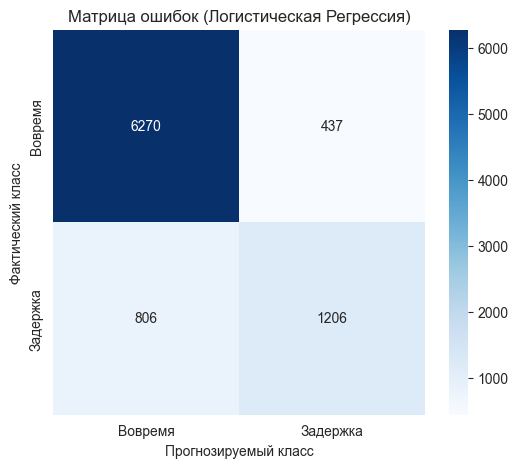

In [46]:
#График матрицы ошибок
cm = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Вовремя', 'Задержка'], yticklabels=['Вовремя', 'Задержка'])
plt.title('Матрица ошибок (Логистическая Регрессия)')
plt.ylabel('Фактический класс')
plt.xlabel('Прогнозируемый класс')
plt.show()

## Модель 3 Сегментация Агентов

In [47]:
#Выбор признаков, связанных с агентами и эффективностью
agent_features = df[['Agent_Age', 'Agent_Rating', 'Delivery_Time']]

#Нормализация данных для кластеризации
scaler_agent = StandardScaler()
X_agent_scaled = scaler_agent.fit_transform(agent_features)

In [ ]:
#Выбор оптимального K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_agent_scaled)
    inertia.append(kmeans.inertia_)

#Метод локтя
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Метод "Локтя" для K-Means')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Сумма квадратов расстояний (Inertia)')
plt.xticks(K_range)
plt.show()